In [1]:
from vizdoom import DoomGame
import time
import random
import numpy as np
import gym
from gym import Env
from gym.spaces import Box, Discrete
import cv2
import matplotlib.pyplot as plt
import torch
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common import env_checker

In [2]:
game = DoomGame()
game.load_config("github/VizDoom/scenarios/defend_the_center.cfg")
game.init()

In [7]:
actions = np.identity(3, dtype=np.uint8)

In [8]:
# Loop through episodes 
episodes = 1
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),1)
        # Print rewward 
        print('reward:', reward) 
    print('Result:', game.get_total_reward())
    time.sleep(2)

reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 1.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
reward: 0.0
rewa

In [9]:
game.close()

In [10]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config('github/VizDoom/scenarios/defend_the_center.cfg')
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            ammo = self.game.get_state().game_variables[0]
            info = ammo
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    # Define how to render the game or environment 
    def render(): 
        pass
    
    # What happens when we start a new game 
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [11]:
env = VizDoomGym(render=False)

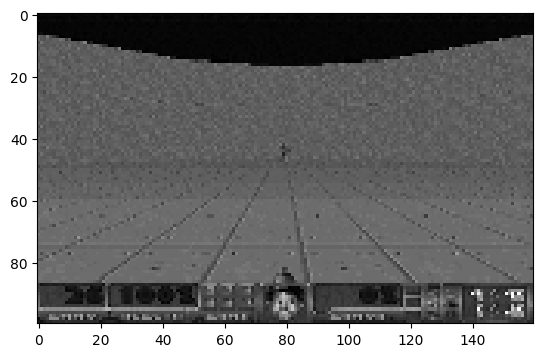

In [13]:
plt.imshow(env.reset(), cmap="gray")
env.close()

In [14]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [15]:
CHECKPOINT_DIR = './train/train_defend_the_center'
LOG_DIR = './logs/log_defend_the_center'

callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [17]:
env = VizDoomGym()
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


D:\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [18]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_defend_the_center\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 81       |
|    ep_rew_mean     | 0.14     |
| time/              |          |
|    fps             | 30       |
|    iterations      | 1        |
|    time_elapsed    | 136      |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 82.6         |
|    ep_rew_mean          | 0.343        |
| time/                   |              |
|    fps                  | 29           |
|    iterations           | 2            |
|    time_elapsed         | 273          |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0068247654 |
|    clip_fraction        | 0.0602       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explain

In [19]:
trained_model = PPO.load("./train/train_defend_the_center/best_model_100000.zip")

In [20]:
env = VizDoomGym(render=True)

for episode in range(10):
    state = env.reset()
    done = False
    while not done:
        pred = trained_model.predict(state)
        state, _, done, _ = env.step(pred[0])
        time.sleep(1/20)
    time.sleep(2)
env.close()